In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = '/MyDrive/Thesis/src/pretrained'
import torch, torchaudio, timm
import numpy as np
from torch.cuda.amp import autocast
import IPython

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=2d3dbede4649c06783d4aea1ecc4db63a882e40b9164574caeacfebbd9227173
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
path='/content/drive/MyDrive/Thesis/src/data/vgg_class.csv'
import pandas as pd
csvFile=pd.read_csv(path, index_col=0)

%cd drive/MyDrive/Thesis/
from src.ast_models import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%cd ~

model = ASTModel(label_dim=57,input_tdim=1024, imagenet_pretrain=False, audioset_pretrain=False)
model = nn.DataParallel(model)
sd = torch.load('/content/drive/MyDrive/Thesis/src/pretrained/best_audio_model.pth', map_location=device)
model.load_state_dict(sd)

/content/drive/MyDrive/Thesis


/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


/root
---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212


<All keys matched successfully>

In [ ]:
model.eval()

DataParallel(
  (module): ASTModel(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dro

In [ ]:

def make_aud(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank

a = '/content/drive/MyDrive/Thesis/src/data/test.webm.wav'
aud = make_aud(a,mel_bins=128)
aud = aud.expand(1, 1024, 128)
aud = aud.to(device)

In [ ]:
with torch.no_grad():
  with autocast():
    output = model.forward(aud)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

In [ ]:
print('Prediced results:')
for k in range(10):
    print('- {}: {:.4f}'.format(csvFile.iloc[sorted_indexes[k]]['display_name'], result_output[sorted_indexes[k]]))
IPython.display.Audio(a)

Prediced results:
- cello: 0.9993
- violin: 0.9984
- double_bass: 0.9099
- oboe: 0.8731
- erhu: 0.7874
- electric_guitar: 0.7565
- clarinet: 0.7118
- tuning_fork: 0.6462
- harp: 0.6308
- french_horn: 0.6129


In [ ]:
class ModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list
model = ModelVis(label_dim=57,input_tdim=1024, imagenet_pretrain=False, audioset_pretrain=False)
model = nn.DataParallel(model)
sd = torch.load('/content/drive/MyDrive/Thesis/src/pretrained/best_audio_model.pth', map_location=device)
model.load_state_dict(sd)


---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212


<All keys matched successfully>

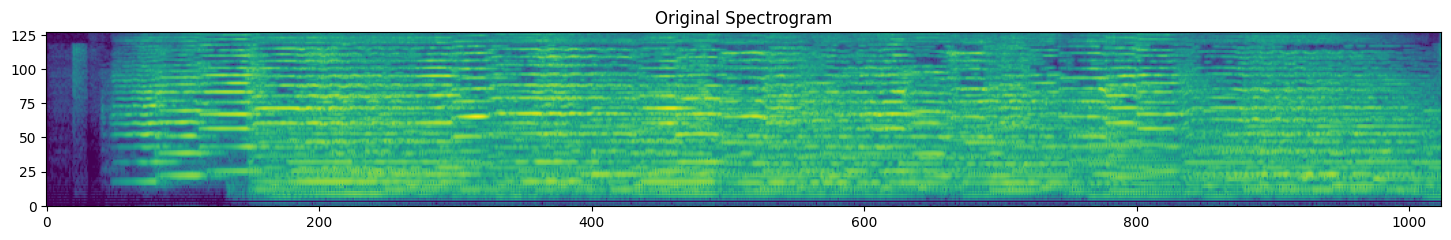

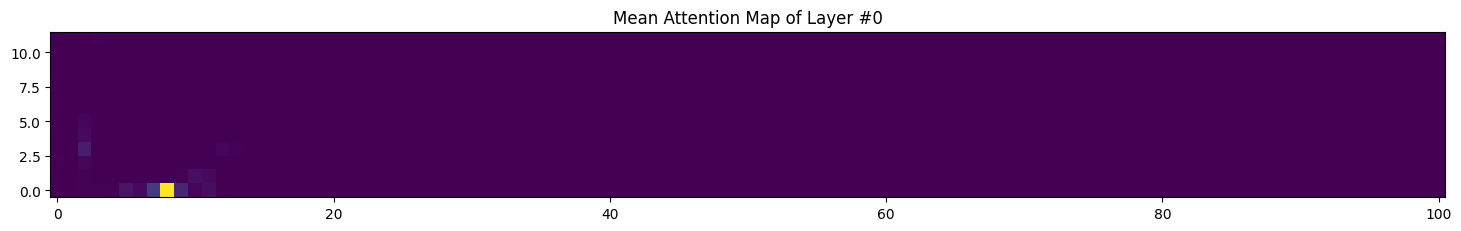

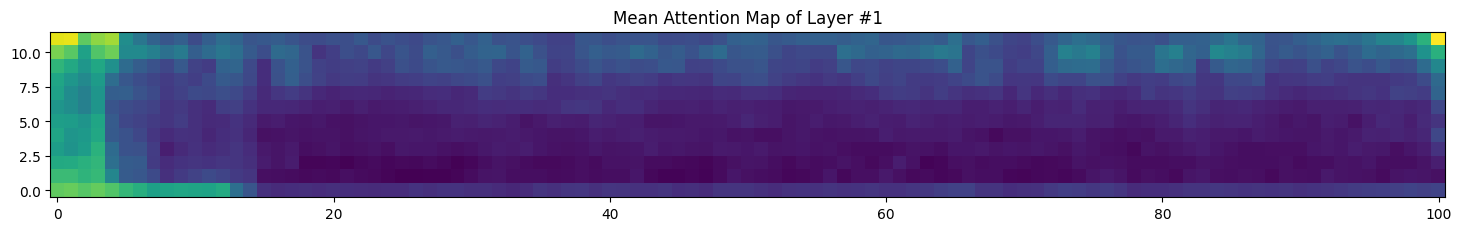

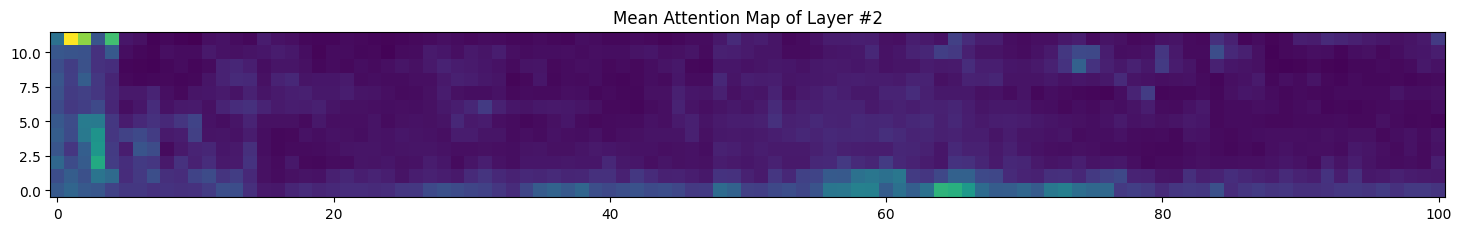

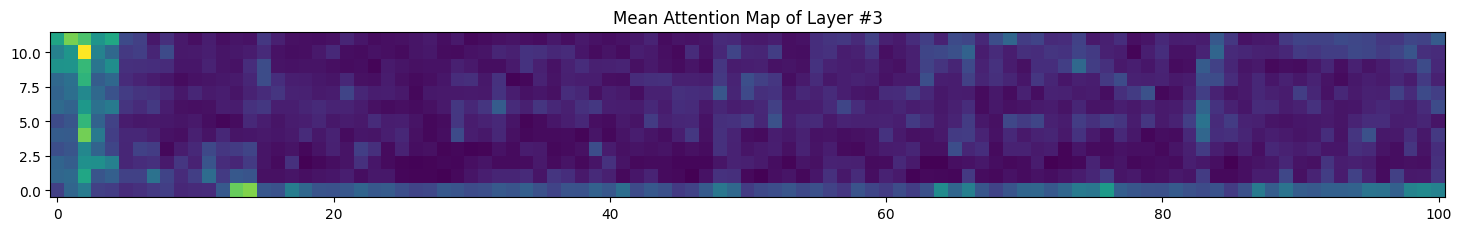

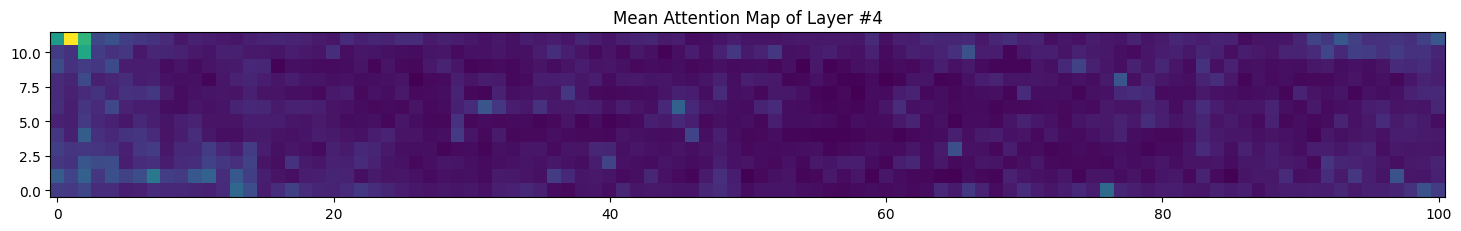

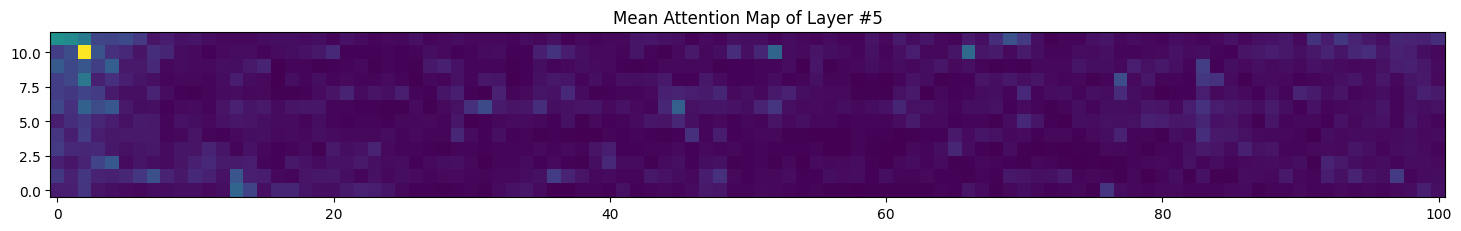

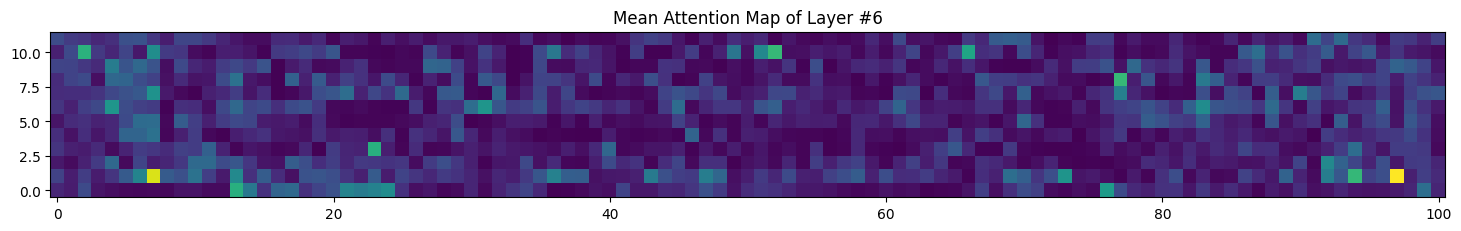

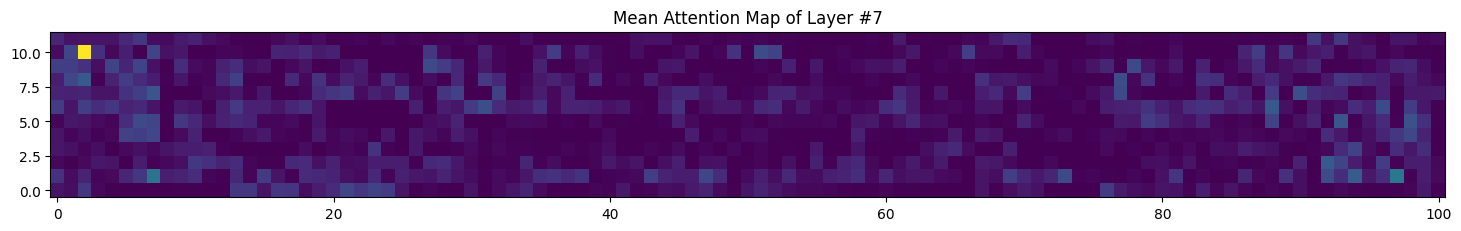

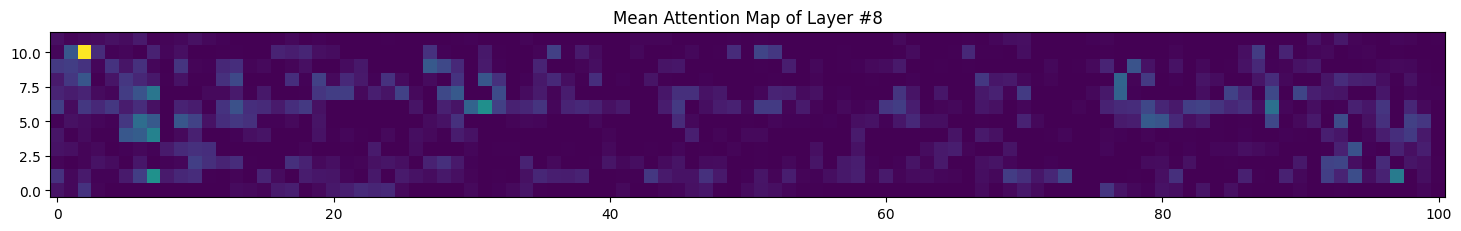

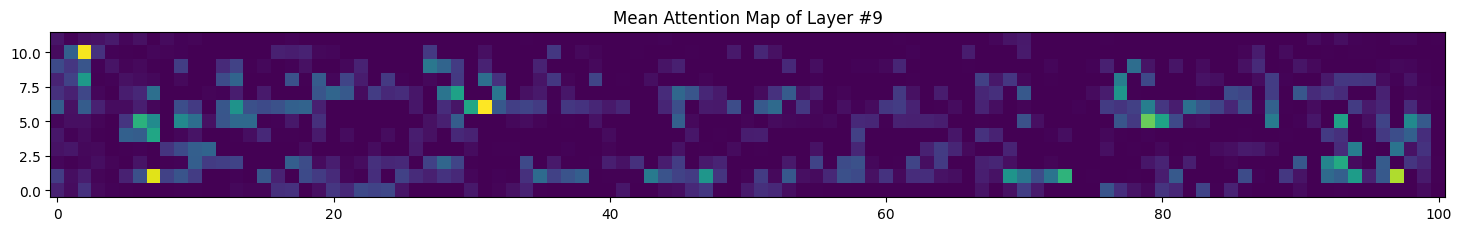

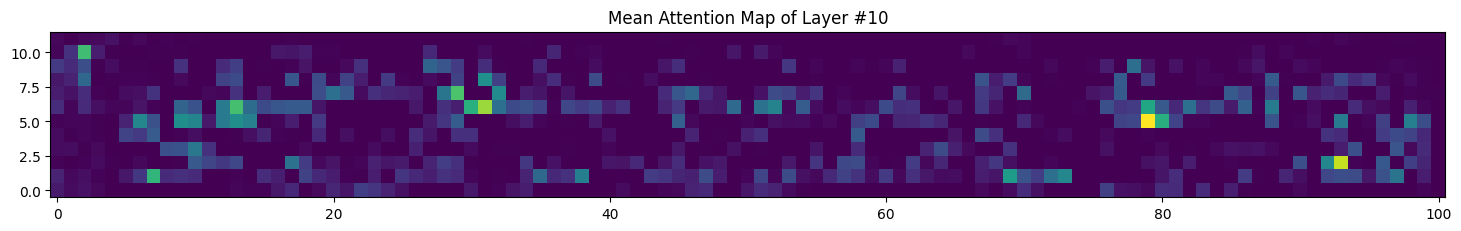

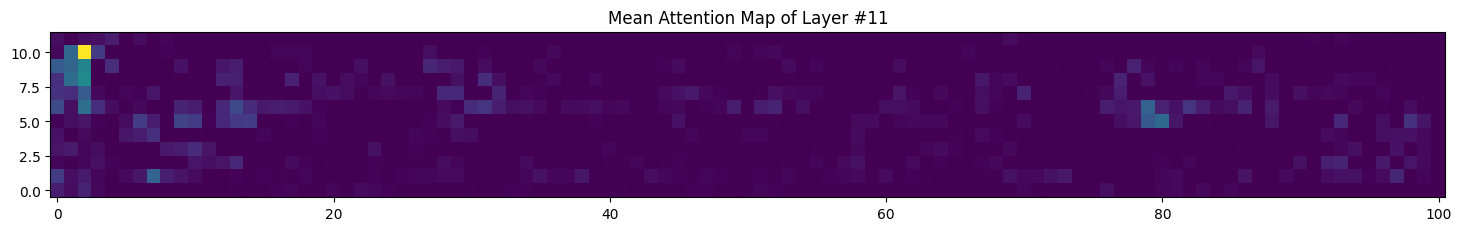

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(18, 5))
ax.imshow(aud[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
with torch.no_grad():
  with autocast():
    att_list = model.module.forward_visualization(aud)
for i in range(len(att_list)):
  att_list[i] = att_list[i].data.cpu().numpy()
  att_list[i] = np.mean(att_list[i][0], axis=0)
  att_list[i] = np.mean(att_list[i][0:2], axis=0)
  att_list[i] = att_list[i][2:].reshape(12, 101)
  fig, ax = plt.subplots(figsize=(18, 5))
  ax.imshow(att_list[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()